In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from matplotlib.lines import Line2D
from tqdm import *
from itertools import compress
from scipy.optimize import bisect
import math
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle
%matplotlib inline  

In [2]:
# Plot font sizes

fs_labels = 26
fs_ticks = 25
fs_text = 23
fs_legend = 22

# Semi-visible jets

This notebook contains plots for our paper on dark parton showers at the LHC.

In [3]:
def combine_background_files(folder='../data/bkg_Zj/', lumi=37*1000, nfiles=200, cut=None, kf=1.0):
    """ Read .evt and .meta files as output by monojet.C and 
        properly weigh events
    """
    
    evt_frames = [pd.read_csv(folder+'events_'+str(i)+'.evt', header=0, delimiter=',', skipinitialspace=True) for i in range(nfiles)]
    good_frames = np.array([len(evt_frame) for evt_frame in evt_frames]) > 0
    
    evt_frames = list(compress(evt_frames, good_frames))
    meta_frames = [pd.read_csv(folder+'events_'+str(i)+'.meta', header=0, delimiter=',', skipinitialspace=True) for i in compress(range(nfiles),good_frames)]
    sum_weights = np.sum([meta_frame['sum_weight'] for meta_frame in meta_frames])
    
    for evt_frame, meta_frame in zip(evt_frames, meta_frames):
        evt_frame['weight'] *= (meta_frame['cxn']*lumi/sum_weights)[0]*5000*kf

    data = pd.concat(evt_frames)
    
    if cut is not None:
        data = data.query(cut)
    return data

In [4]:
def to_str(num):
    if .2 <= num <= .9:
        return '{:.1g}'.format(num)[-2:]
    elif num == 0:
        return '0.0'
    elif num == 0.99:
        return '0.99'
    elif num == 1:
        return '1.0'
    else:
        return str(num)

def combine_signal_files(folder='../data/bkg_Zj/', mphi = 1700, rinv = 1, lumi=37*1000, nfiles=4, cut = None,extra='', return_cxn = False):
    """ Read .evt and .meta files as output by monojet.C and 
        properly weigh events
    """
    
    evt_frames = [pd.read_csv(folder+'events_'+str(extra)+str(mphi)+"_"+to_str(rinv)+"_"+str(i)+'.evt', header=0, delimiter=',', skipinitialspace=True) for i in range(nfiles)]
    good_frames = np.array([len(evt_frame) for evt_frame in evt_frames]) > 0
    
    evt_frames = list(compress(evt_frames, good_frames))
    meta_frames = [pd.read_csv(folder+'events_'+str(extra)+str(mphi)+"_"+to_str(rinv)+"_"+str(i)+'.meta', header=0, delimiter=',', skipinitialspace=True) for i in compress(range(nfiles),good_frames)]
    sum_weights = np.sum([meta_frame['sum_weight'] for meta_frame in meta_frames])
    mean_cxn  = np.mean([meta_frame['cxn'] for meta_frame in meta_frames])
    for evt_frame, meta_frame in zip(evt_frames, meta_frames):
        evt_frame['weight'] *= (meta_frame['cxn']*lumi/sum_weights)[0]

    data = pd.concat(evt_frames)
    
    if cut is not None:
        data = data.query(cut)
    if return_cxn:
        return data, mean_cxn
    else:
        return data

In [5]:
def get_bkg(bkg, cut=None):
    if cut is not None:
        new_bkg = bkg.query(cut)
    else: 
        new_bkg = bkg
    return np.sum(np.histogram(new_bkg['MEt'].values, weights=new_bkg['weight'].values)[0])

def get_sig(sig, cut=None):
    if cut is not None:
        new_bkg = sig.query(cut)
    else: 
        new_bkg = sig
    return np.sum(np.histogram(new_bkg['MEt'].values, weights=new_bkg['weight'].values)[0])

In [6]:
def limit(sig,bkg):
    if np.sum(sig)==0:
        return 1e99
    def func_root(x):
        part1 = bkg > 20
        part2 = np.logical_not(part1)
        qcd_1 = bkg[part1]
        qcd_2 = bkg[part2]
        sig_1 = sig[part1]
        sig_2 = sig[part2]

        sig_t1 = (10**x)*sig_1
        sig_t2 = (10**x)*sig_2
        
        sb1 = qcd_1 + sig_1
        sb2 = qcd_2 + sig_2
        
        normpart = sig_t1**2/(2*(sb1))
        logpart = np.where(qcd_2 > 1e-3, -qcd_2*np.log(1+sig_t2/qcd_2), 0)
        my_val = np.sum(normpart)+(np.sum(logpart)+np.sum(sig_t2)) - 2
        return my_val
    
    
    soln = bisect(func_root, -10.,20.)
    return 10**soln

def signif(s, b ):
    return s/np.sqrt(s+b)

In [7]:
def round_sigfigs(num, sig_figs):
    """Round to specified number of sigfigs.

    >>> round_sigfigs(0, sig_figs=4)
    0
    >>> int(round_sigfigs(12345, sig_figs=2))
    12000
    >>> int(round_sigfigs(-12345, sig_figs=2))
    -12000
    >>> int(round_sigfigs(1, sig_figs=2))
    1
    >>> '{0:.3}'.format(round_sigfigs(3.1415, sig_figs=2))
    '3.1'
    >>> '{0:.3}'.format(round_sigfigs(-3.1415, sig_figs=2))
    '-3.1'
    >>> '{0:.5}'.format(round_sigfigs(0.00098765, sig_figs=2))
    '0.00099'
    >>> '{0:.6}'.format(round_sigfigs(0.00098765, sig_figs=3))
    '0.000988'
    """
    if num != 0:
        return round(num, -int(math.floor(math.log10(abs(num))) - (sig_figs - 1)))
    else:
        return 0  # Can't take the log of 0



## Background validation

Validate against IM1 signal region in the ATLAS monojet study (https://arxiv.org/abs/1704.03848).

In [8]:
cuts = 'MEt > 250 & pt1 > 250 & eta1 < 2.4 & eta1 > -2.4 & dphi > 0.4 & nj < 5'

### W+jets

In [9]:
Wj_df = combine_background_files('../data/bkg_Wj/', nfiles=200, lumi = 3.2*1000, kf=1.0)

In [10]:
N = np.sum(np.histogram(Wj_df.query(cuts)['MEt'].values,weights=Wj_df.query(cuts)['weight'].values)[0])
print N, N*1.3

7882.64499791 10247.4384973


In [11]:
# ATLAS events
1710+1950+3980

7640

### Z+jets

In [12]:
Zj_df = combine_background_files('../data/bkg_Zj/', nfiles=200, lumi = 3.2*1000, kf=1.)

In [13]:
N = np.sum(np.histogram(Zj_df.query(cuts)['MEt'].values,weights=Zj_df.query(cuts)['weight'].values)[0])
print N, N*1.3

11400.6360258 14820.8268336


In [14]:
# ATLAS events
12520+48+76

12644

In [15]:
# K-factor
12644/11400.6360258

1.109060930581963

### $t\bar t$

In [16]:
tt_d_df = combine_background_files('../data/bkg_ttbar_dilep//', nfiles=200, lumi = 3.2*1000, kf=1.)
tt_s_df = combine_background_files('../data/bkg_ttbar_semilep//', nfiles=200, lumi = 3.2*1000, kf=1.)

tt_df = pd.concat([tt_d_df, tt_s_df])

In [17]:
N = np.sum(np.histogram(tt_df.query(cuts)['MEt'].values,weights=tt_df.query(cuts)['weight'].values)[0])
print N, N*1.3

447.153346562 581.299350531


In [18]:
# ATLAS events
780

780

In [19]:
#K-factor
780/447.153346562

1.7443680249675804

## Fig. 6: SM background distributions

In [20]:
Zj_df = combine_background_files('../data/bkg_Zj/', nfiles=1000, kf=1.1)
Wj_df = combine_background_files('../data/bkg_Wj/', nfiles=1000, kf=1.0)
tt_d_df = combine_background_files('../data/bkg_ttbar_dilep//', nfiles=1000, kf=1.7)
tt_s_df = combine_background_files('../data/bkg_ttbar_semilep//', nfiles=1000, kf=1.7)
QCD_df = combine_background_files('../data/bkg_qcd//', nfiles=2000, kf=1.0)

tt_df = pd.concat([tt_d_df, tt_s_df])
ewk_df = pd.concat([Zj_df, Wj_df])

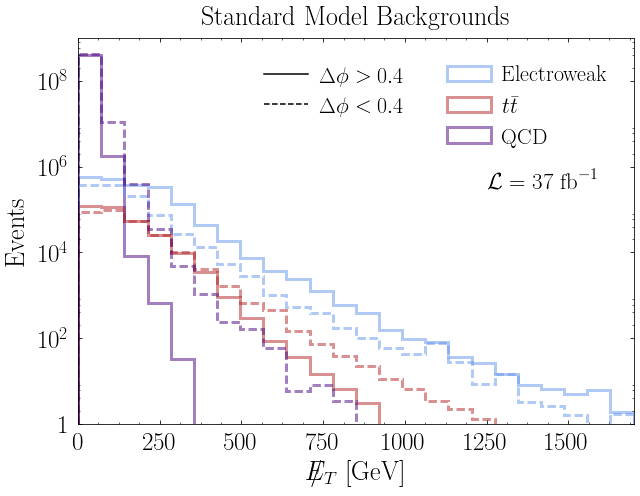

In [21]:
title = "Standard Model Backgrounds"
bins = np.linspace(0,1700,25)
normed = False
plt.figure(figsize=(9,7))
plot_colors=['cornflowerblue','mediumseagreen', 'firebrick','indigo','violet','maroon','darkgrey','lightpink','black','forestgreen','cornflowerblue', 'salmon','violet','goldenrod','maroon','darkgrey','lightpink']
cut = 'dphi > 0.4'

plt.hist(ewk_df.query(cut)['MEt'], weights=ewk_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="Electroweak", normed=normed, color=plot_colors[0])

plt.hist(tt_df.query(cut)['MEt'], weights=tt_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="$t\\bar t$", normed=normed, color=plot_colors[2])

plt.hist(QCD_df.query(cut)['MEt'], weights=QCD_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="QCD", normed=normed, color=plot_colors[3])

cut = 'dphi < 0.4'

plt.hist(ewk_df.query(cut)['MEt'], weights=ewk_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, normed=normed, color=plot_colors[0], ls='--')

plt.hist(tt_df.query(cut)['MEt'], weights=tt_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3,  normed=normed, color=plot_colors[2], ls='--')

plt.hist(QCD_df.query(cut)['MEt'], weights=QCD_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, normed=normed, color=plot_colors[3], ls='--')

plt.xlabel(r'$\slash \!\!\!\! E_{T}$ [GeV]',fontsize=fs_labels)

plt.ylim(1e0,1e9)
plt.title(title, fontsize=fs_labels)

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])


handles,labels = ax.get_legend_handles_labels()
handles = [Line2D([],[],color='k')] + [Line2D([],[],color='k',ls='--')] + [Line2D([],[],alpha=0)] + [Line2D([],[],alpha=0)] + [handles[i] for i in range(3)] #, handles[2]]
labels = [r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$',"","",labels[0],labels[1],labels[2]] #, labels[2]]
leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=22, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)
plt.xlim(0,1700)
plt.text(1250,3*10**5,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=fs_text)

plt.tick_params(axis='both', which='major', labelsize=fs_ticks)

plt.ylabel("Events",fontsize = fs_labels)
plt.yscale("log")
ax.set_yscale("log")
# ax.get_yaxis().set_major_formatter(ScalarFormatter())
# ax.yaxis.major.formatter.set_powerlimits((-4,-3))

# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,3))

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))

plt.tight_layout()

plt.savefig("backgrounds_met.pdf")

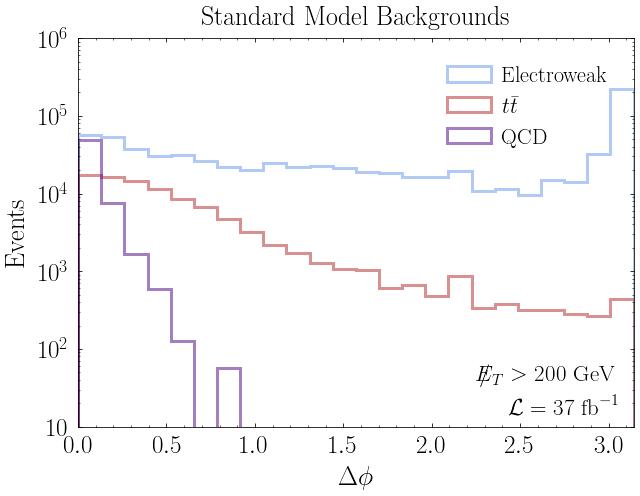

In [22]:
bins = np.linspace(0,np.pi,25)
normed = False
fig=plt.figure(figsize=(9,7))
plot_colorsss=['cornflowerblue','mediumseagreen', 'firebrick','indigo','violet','maroon','darkgrey','lightpink','black','forestgreen','cornflowerblue', 'salmon','violet','goldenrod','maroon','darkgrey','lightpink']
cut = 'MEt > 200'

plt.hist(ewk_df.query(cut)['dphi'], weights=ewk_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="Electroweak", normed=normed, color=plot_colorsss[0])

plt.hist(tt_df.query(cut)['dphi'], weights=tt_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="$t\\bar t$", normed=normed, color=plot_colorsss[2])

plt.hist(QCD_df.query(cut)['dphi'], weights=QCD_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="QCD", normed=normed, color=plot_colorsss[3])


plt.ylim(10,1e6)
ax = plt.gca()

plt.title(title, fontsize=fs_labels)
ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])



handles,labels = ax.get_legend_handles_labels()
# handles = [Line2D([],[],color='k')] + [Line2D([],[],color='k',ls='--')] + [Line2D([],[],color=plot_colorss[i],alpha=0)] + [Line2D([],[],color=plot_colorss[i],alpha=0)] + [Line2D([],[],color=plot_colorss[i]) for i in range(4)] #, handles[2]]
# labels = [r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$',"","",labels[0],labels[1],labels[2],labels[3]] #, labels[2]]
leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=22, ncol=1,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)

plt.tick_params(axis='both', which='major', labelsize=fs_ticks)
plt.xlabel("$\Delta\phi$",fontsize=fs_labels)
plt.tight_layout()
plt.ylabel("Events",fontsize=fs_labels)
plt.yscale("log")
plt.xlim(0,np.pi)
plt.text(2.43,14,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=fs_text)
plt.text(2.25,35,"$\slash \!\!\!\! E_{T} >$ 200 GeV",fontsize=fs_text)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))

plt.tight_layout()
plt.savefig("backgrounds_dphi.pdf")

## Fig. 5: Contact operator distributions

In [23]:
rinvs = [.00, .3, .6, 1.0 ]

sig10 = [ combine_signal_files('../data//sig_zprime//', 100000, rinv,nfiles=12) for rinv in rinvs  ]
cxn10 = [ combine_signal_files('../data/sig_zprime/', 100000, rinv ,return_cxn=True,nfiles=12)[1] for rinv in rinvs ]

sig100 = [ combine_signal_files('../data/sig_zprime/', 100000, rinv,nfiles=12, extra = '100_') for rinv in rinvs  ]
cxn100 = [ combine_signal_files('../data/sig_zprime/', 100000, rinv,nfiles=12, extra = '100_',return_cxn=True)[1] for rinv in rinvs  ]

In [24]:
plot_colorss=['cornflowerblue','mediumseagreen', 'firebrick','indigo','violet','maroon','darkgrey','lightpink','black','forestgreen','cornflowerblue', 'salmon','violet','goldenrod','maroon','darkgrey','lightpink']

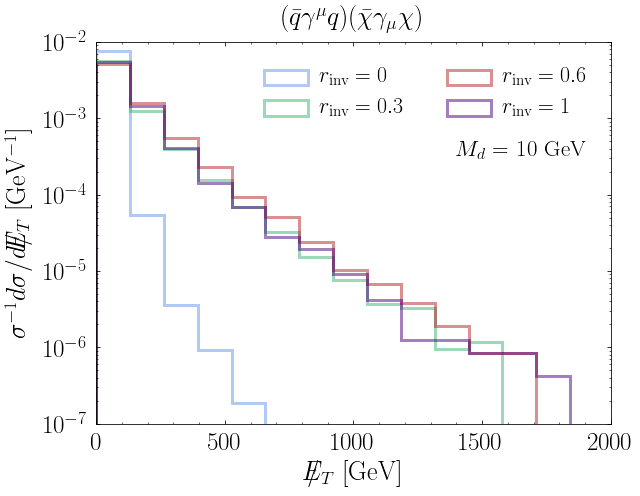

In [25]:
title = "$(\\bar q \gamma^\mu q)(\\bar \chi \gamma_\mu \chi)$"

lumi = 37000
bins = bins=np.linspace(0,2500,20)
fig=plt.figure(figsize=(9,7))
bw = bins[12]-bins[11] # bin width

for irinv, rinv in enumerate(rinvs):
    plt.hist(sig10[irinv]['MEt'], weights=len(sig10[irinv])*[1/len(sig10[irinv])/bw], lw=3, ls = 'solid', label="$r_{\\rm inv}=%0.2g$" % rinv, histtype='step', color=plot_colorss[irinv],alpha=.5, bins=bins)


    
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\slash \!\!\!\! E_{T}$ [GeV]',fontsize=fs_labels)
plt.ylabel(r'${\sigma^{-1}d\sigma/d\slash \!\!\!\! E_{T}}$ [GeV$^{-1}$]',fontsize=fs_labels)  
plt.xlim([0,2000])


plt.title(title, fontsize=fs_labels)
ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

handles,labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in range(4)] #, handles[2]]
labels = [labels[0],labels[1],labels[2],labels[3]] #, labels[2]]
leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=fs_legend, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)

plt.text(1400, 0.0003, "$M_d$ = 10 GeV",fontsize=fs_text)
plt.tick_params(axis='both', which='major', labelsize=fs_ticks)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))
plt.ylim(1e-7,1e-2)
plt.tight_layout()
plt.savefig("contact_met.pdf")

In [26]:
# Testing black and white appropriateness
# from PIL import Image
# Image.open('met_sig.png').convert('LA')

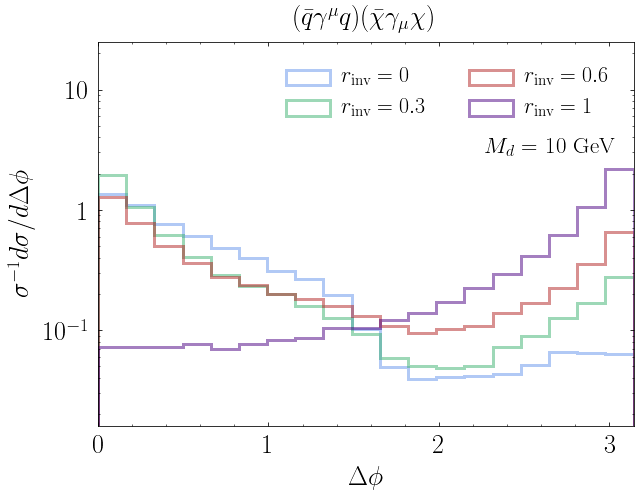

In [27]:
lumi = 37000
bins=np.linspace(0,np.pi,20)
fig=plt.figure(figsize=(9,7))
bw = bins[12]-bins[11] # bin width
cut = 'MEt > 0'
for irinv, rinv in enumerate(rinvs):
    plt.hist(sig10[irinv]['dphi'], weights=len(sig10[irinv])*[1/len(sig10[irinv])/bw], lw=3, ls = 'solid', label="$r_{\\rm inv}=%0.2g$" % rinv, histtype='step', color=plot_colorss[irinv],alpha=.5, bins=bins)

#     plt.hist(sig100[irinv].query(cut)['dphi'], weights=sig100[irinv].query(cut)['weight'].values/cxn100[irinv]/lumi, lw=0, ls = '--', label="$r_{\\rm inv}=%0.2g$" % rinv, histtype='step', color=plot_colorss[irinv],alpha=.5, bins=bins)


    
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\Delta\phi$',fontsize=fs_labels)
plt.ylabel(r'${\sigma^{-1}d\sigma/d\Delta\phi$',fontsize=fs_labels)  
plt.xlim([0,np.pi])
# plt.ylim(10**0,10**3)

plt.title(title, fontsize=fs_labels)
ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

handles,labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in range(4)] #, handles[2]]
labels = [labels[0],labels[1],labels[2],labels[3]] #, labels[2]]
leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=fs_legend, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))

plt.text(2.27, 2.85, "$M_d$ = 10 GeV",fontsize=fs_text)
plt.ylim(0.016,25)
plt.tick_params(axis='both', which='major', labelsize=fs_labels)
plt.tight_layout()
plt.savefig("contact_dphi.pdf")

## Appendix: UV-completion distributions

In [28]:
# make histograms
def newfig(name):
    fig=plt.figure(name,figsize=(9,7))
    plt.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.2)

    
def plot_met_cell(cell, sig, lw=3, ls='solid', label="temp", fudge=1., **kwargs):
    newfig("met")
    bins=np.linspace(0,2500,20)
    bw = bins[12]-bins[11]
    cell.hist(sig['MEt'], weights=len(sig)*[1/len(sig)/bw], 
             bins=bins,
             histtype='step',alpha=.5, lw=1.6, linestyle=ls,
             label=label, **kwargs)
    cell.set_xlim([0,2500])
    cell.set_yscale('log', nonposy='clip')

def plot_dphi_cell(cell, sig, lw=3, ls='solid', label="temp", fudge=1., **kwargs):
    newfig("met")
    bins=np.linspace(0,np.pi,20)
    bw = bins[1]-bins[0]
    cell.hist(sig['dphi'], weights=len(sig)*[1/len(sig)/bw],  
             bins=bins,
             histtype='step',alpha=.5, lw=1.6, linestyle=ls,
             label=label, **kwargs)
    cell.set_xlim([0,np.pi])
    cell.set_yscale('log', nonposy='clip')

In [29]:
rinvs = [0,0.3,.6, 1.0]
masses = [500,1000,2000,3000,5000,10000]

In [30]:
plot_colors=['cornflowerblue','mediumseagreen', 'firebrick','indigo','violet','maroon','darkgrey','lightpink','black','forestgreen','cornflowerblue', 'salmon','violet','goldenrod','maroon','darkgrey','lightpink']
plot_ls=['solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid']

3it [00:12,  4.32s/it]


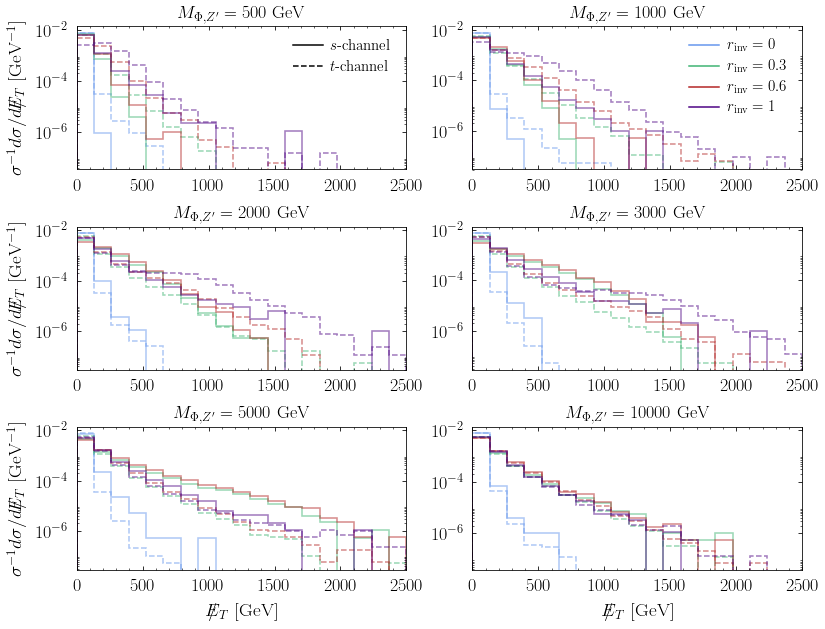

In [31]:
fig, axes2d = plt.subplots(nrows=3, ncols=2,
                           figsize=(13,10))


for i, row in tqdm(enumerate(axes2d)):
    for j, cell in enumerate(row):
        M = masses[i*2 + j]
        
        sig10 = [ combine_signal_files('../data/sig_zprime//', M, rinv) for rinv in rinvs  ]
        cxn10 = [ combine_signal_files('../data/sig_zprime/', M, rinv,return_cxn=True)[1] for rinv in rinvs  ]
        sig10_tch = [ combine_signal_files('../data/sig_tchannel/', M, rinv, nfiles=1) for rinv in rinvs  ]
        cxn10_tch = [ combine_signal_files('../data/sig_tchannel/', M, rinv, nfiles=1,return_cxn=True)[1] for rinv in rinvs  ]
        
        for irinv, rinv in enumerate(rinvs):
            plot_met_cell(cell, sig=sig10[irinv], lw=2, ls = 'solid', label="$r_{\\rm inv}=%0.2g$" % rinv, fudge=1/cxn10[irinv], color=plot_colors[irinv])
            plot_met_cell(cell, sig=sig10_tch[irinv], lw=2, ls = '--', label=str(rinv), fudge=1/cxn10_tch[irinv], color=plot_colors[irinv])
        
        if i*2 + j in range(4,6):
            cell.set_xlabel(r'$\slash \!\!\!\! E_{T}$ [GeV]',fontsize=19)
        if (i*2 + j) % 2 == 0:
            cell.set_ylabel(r'${\sigma^{-1}d\sigma/d\slash \!\!\!\! E_{T}}$ [GeV$^{-1}$]',fontsize=19)

        if (i*2 + j) == 0:
            handles = [Line2D([],[],color='k',ls='solid'), Line2D([],[],color='k',ls='--')]
            labels = ["$s$-channel","$t$-channel"] #, labels[2]]
            leg = cell.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=15, ncol=1,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)



        if (i*2 + j) == 1:
            handles,labels = cell.get_legend_handles_labels()
            handles = [Line2D([],[],color=plot_colors[i]) for i in range(4)] #, handles[2]]
            labels = [labels[0], labels[2],labels[4],labels[6]] #, labels[2]]
            leg = cell.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=15, ncol=1,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)


#             cell.legend(title="rinv")
            
        cell.set_title("$M_{\Phi,Z^{\prime}} = $ "+str(M)+" GeV")

fig.subplots_adjust(wspace=.2, hspace=.4)
# plt.tight_layout()
fig.savefig("approaching_contact_met.pdf")

3it [00:12,  4.26s/it]


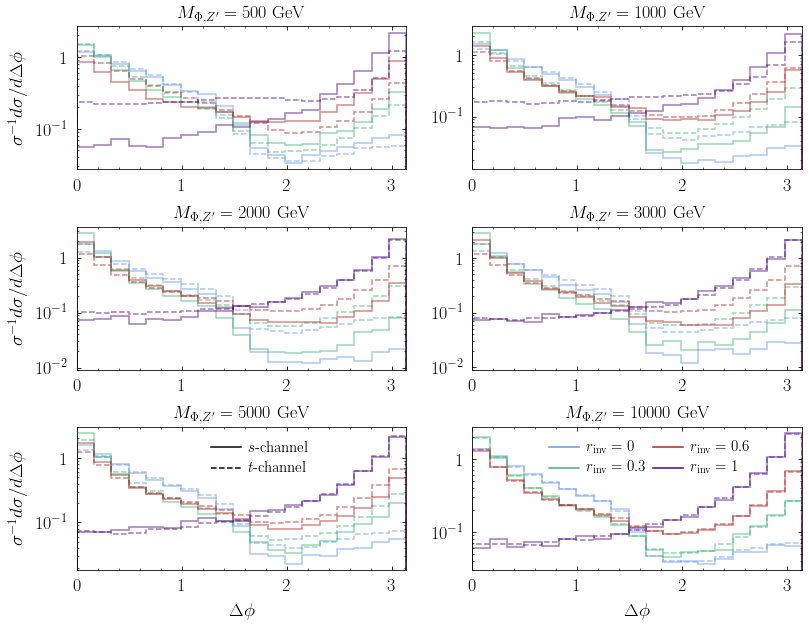

In [32]:
fig, axes2d = plt.subplots(nrows=3, ncols=2,
                           figsize=(13,10))


for i, row in tqdm(enumerate(axes2d)):
    for j, cell in enumerate(row):
        M = masses[i*2 + j]
        
        sig10 = [ combine_signal_files('../data/sig_zprime//', M, rinv) for rinv in rinvs  ]
        cxn10 = [ combine_signal_files('../data/sig_zprime/', M, rinv,return_cxn=True)[1] for rinv in rinvs  ]
        sig10_tch = [ combine_signal_files('../data/sig_tchannel/', M, rinv, nfiles=1) for rinv in rinvs  ]
        cxn10_tch = [ combine_signal_files('../data/sig_tchannel/', M, rinv, nfiles=1,return_cxn=True)[1] for rinv in rinvs  ]

        for irinv, rinv in enumerate(rinvs):
            plot_dphi_cell(cell, sig=sig10[irinv], lw=2, ls = 'solid', label="$r_{\\rm inv}=%0.2g$" % rinv, fudge=1/cxn10[irinv], color=plot_colors[irinv])
            plot_dphi_cell(cell, sig=sig10_tch[irinv], lw=2, ls = '--', label=str(rinv), fudge=1/cxn10_tch[irinv], color=plot_colors[irinv])
        
        if i*2 + j in range(4,6):
            cell.set_xlabel(r'$\Delta\phi$',fontsize=19)
        if (i*2 + j) % 2 == 0:
            cell.set_ylabel(r'$\sigma^{-1}d\sigma/d\Delta\phi$',fontsize=19)

        if (i*2 + j) == 4:
            handles = [Line2D([],[],color='k',ls='-'), Line2D([],[],color='k',ls='--')]
            labels = ["$s$-channel","$t$-channel"] #, labels[2]]
            leg = cell.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=15, ncol=1,frameon=False,
           handletextpad=.5,
           borderaxespad=0., loc=(0.4,0.65))



        if (i*2 + j) == 5:
            handles,labels = cell.get_legend_handles_labels()
            handles = [Line2D([],[],color=plot_colors[i]) for i in range(4)] #, handles[2]]
            labels = [labels[0], labels[2],labels[4],labels[6]] #, labels[2]]
            leg = cell.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=15, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0., loc = (.22,0.65),columnspacing=0.45)

# ticklabels = ["$10^{-3}$","$10^{-2}$","$10^{-1}$","$1$","$10$","$10^2$"]
# ax.set_yticklabels(ticklabels)

        cell.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))



#             cell.legend(title="rinv")
            
        cell.set_title("$M_{\Phi,Z^{\prime}} = $ "+str(M)+" GeV")

fig.subplots_adjust(wspace=.2, hspace=.4)
# plt.tight_layout()
fig.savefig("approaching_contact_dphi.pdf")

## Fig. 7: Contact operator limits

In [33]:
bkgs = [Zj_df, Wj_df, tt_d_df, tt_s_df, QCD_df]

In [34]:
cutlist=[]
basecut = 'pt1 > 250 & '

for MEtcut in [400,600,800,1000,1200]:
    for dphicut in ['dphi < 0.4', 'dphi > 0.4']:
        # Do not let MET cut go < 800 if dphi < 0.4
        if dphicut == 'dphi < 0.4' and MEtcut < 800: continue 
        c1 = 'MEt > ' + str(MEtcut) + ' & '
        cutlist =  cutlist + [basecut + c1 + dphicut ]

In [35]:
bkg_list= [np.sum([get_bkg(bkg, cut) for bkg in bkgs]) for cut in tqdm(cutlist) ] 

100%|██████████| 8/8 [00:00<00:00, 10.80it/s]


In [36]:
masses = [100000]
rinvs = [0.0, 0.01,0.1,.2,.3,.4,.5,.6,.7,.8,.9, 0.99, 1.0]

In [37]:
cxn10 = [ combine_signal_files('../data/sig_zprime///', 100000, rinv, extra = '' , nfiles=16, return_cxn=True)[1] for rinv in rinvs ]
cxn100 = [ combine_signal_files('../data/sig_zprime////', 100000, rinv, extra = '100_', nfiles=16,return_cxn=True)[1] for rinv in rinvs  ]

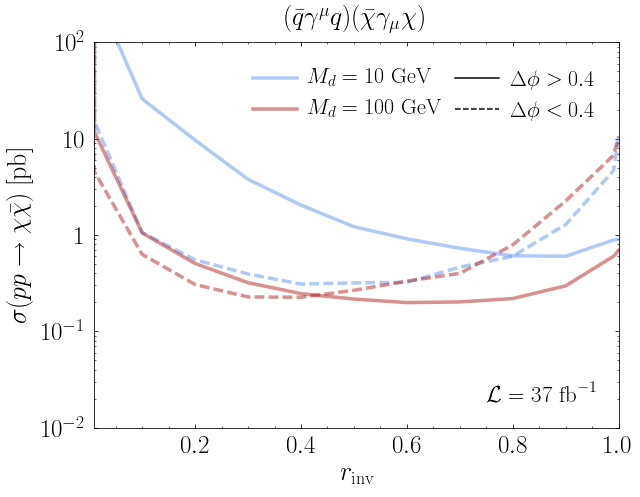

In [38]:
newfig("exc")
title = "$(\\bar q \gamma^\mu q)(\\bar \chi \gamma_\mu \chi)$"


result_less=np.zeros([len(rinvs)])
result_gtr=np.zeros([len(rinvs)])

cutindex_less=np.zeros([len(rinvs)],dtype=int)
cutindex_gtr=np.zeros([len(rinvs)],dtype=int)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime//////", mphi = 100000, rinv = r, extra = '', nfiles=16);

    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)

contact_cxn_less = result_less*cxn10
contact_cxn_gtr = result_gtr*cxn10


plt.plot(rinvs, result_less*cxn10, lw=3.5, ls='--',
                 color='cornflowerblue',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn10, lw=3.5,
                 color='cornflowerblue', label=r'$M_d = 10 ~\mathrm{GeV}$',alpha=.5)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime/////", mphi = 100000, rinv = r,extra = '100_', nfiles=16);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)


plt.plot(rinvs, result_less*cxn100, lw=3.5, ls='--',
                 color='firebrick',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn100, lw=3.5,
                 color='firebrick', label=r'$M_d = 100 ~\mathrm{GeV}$',alpha=.5)



plt.yscale('log', nonposy='clip')
plt.xlabel(r'$r_{\rm inv}$',fontsize=fs_labels)
plt.ylabel(r'$\sigma(pp \rightarrow \chi \bar\chi) \;[{\rm pb}]$',fontsize=fs_labels)
plt.xlim([0.01,1.0])
plt.ylim([1e-2, 1e2])
plt.title(title, fontsize=fs_labels)


plt.legend(loc='upper right',
           fontsize=fs_legend, ncol=1,frameon=False, fancybox=True)

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

# ticklabels = ["$10^{-3}$","$10^{-2}$","$10^{-1}$","$1$","$10$","$10^2$"]
# ax.set_yticklabels(ticklabels)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))


plt.tick_params(axis='both', which='major', labelsize=fs_ticks)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in [1,3]] + [Line2D([],[],color='k')]  + [Line2D([],[],color='k',ls='--')] #, handles[2]]
# handles = [Line2D([],[],color=plot_colorss[i]) for i in [1,3,5]] + [Line2D([],[],color='k')] + [Line2D([],[],color='k',ls='--')] #, handles[2]] + 
labels = [labels[1], labels[3],r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$'] #, labels[2]]

leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=fs_legend, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0., loc='upper right', columnspacing=0.6)




ax = plt.axes()

plt.text(.75,.018,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=fs_text)


plt.tight_layout()
plt.savefig("contact_cxn_lims.pdf")

plt.show()

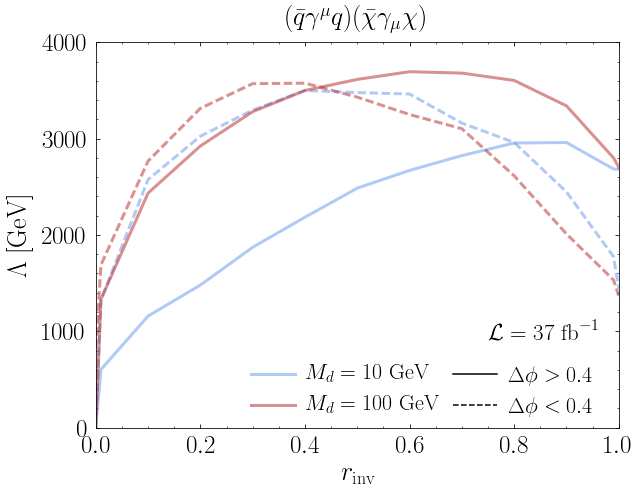

In [39]:
newfig("exc")
cutoff = 100000
title = "$(\\bar q \gamma^\mu q)(\\bar \chi \gamma_\mu \chi)$"


result_less=np.zeros([len(rinvs)])
result_gtr=np.zeros([len(rinvs)])

cutindex_less=np.zeros([len(rinvs)],dtype=int)
cutindex_gtr=np.zeros([len(rinvs)],dtype=int)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime/////", mphi = 100000, rinv = r, extra = '', nfiles=16);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)
    
contact_less = cutoff/(result_less)**(1/4.)/np.sqrt(0.1)
contact_gtr = cutoff/(result_gtr)**(1/4.)/np.sqrt(0.1)

plt.plot(rinvs, contact_less, lw=3, ls='--',
                 color='cornflowerblue',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, contact_gtr, lw=3,
                 color='cornflowerblue', label=r'$M_d = 10 ~\mathrm{GeV}$',alpha=.5)


cutoff = 100000


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime//////", mphi = 100000, rinv = r,extra = '100_', nfiles=16);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)

plt.plot(rinvs, cutoff/(result_less)**(1/4.)/np.sqrt(0.1), lw=3, ls='--',
                 color='firebrick',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, cutoff/(result_gtr)**(1/4.)/np.sqrt(0.1), lw=3,
                 color='firebrick', label=r'$M_d = 100 ~\mathrm{GeV}$',alpha=.5)

# plt.yscale('log', nonposy='clip')
plt.xlabel(r'$r_{\rm inv}$',fontsize=fs_labels)
plt.ylabel(r'$\Lambda$ [GeV]',fontsize=fs_labels)
plt.xlim([0.0,1.0])
# plt.ylim([0, 5000])

plt.title(title, fontsize=fs_labels)


plt.legend(loc='upper right',
           fontsize=fs_legend, ncol=1,frameon=False, fancybox=True)

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

# ticklabels = ["$10^{-3}$","$10^{-2}$","$10^{-1}$","$1$","$10$","$10^2$"]

plt.tick_params(axis='both', which='major', labelsize=fs_ticks)
# ax.set_yticklabels(ticklabels)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in [1,3]] + [Line2D([],[],color='k')]  + [Line2D([],[],color='k',ls='--')] #, handles[2]]
labels = [labels[1], labels[3],r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$'] #, labels[2]]

leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=fs_legend, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0.1, loc = 'lower right', columnspacing=0.6)

plt.text(.75,900,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=fs_text)
plt.ylim(0,4000)

# ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))

plt.tight_layout()
plt.savefig("contact_lambda_lims.pdf")

## Table 1: Contact operator cutflow

In [40]:
cuts = ['' for i in range(4)]
trigger_presel = 'pt1 > 250 & MEt > 200'
cuts[0] = ''
cuts[1] = ' & MEt > 800'
cuts[2] = ' & MEt > 800 & dphi < 0.4'
cuts[3] = ' & MEt > 800 & dphi > 0.4'

In [41]:
bkg_cutflow = [[round_sigfigs(get_bkg(bkg, trigger_presel + cut), 3) for bkg in bkgs] for cut in cuts]
bk_sum = np.sum(bkg_cutflow, axis = 1)

In [42]:
rinvs = 0.1, 0.5, 0.9

In [43]:
sigs = [combine_signal_files('../data/sig_zprime/', 100000, rinv, extra = '' , nfiles=16, return_cxn=True)[0] for rinv in rinvs]
cxns = [combine_signal_files('../data/sig_zprime/', 100000, rinv, extra = '' , nfiles=16, return_cxn=True)[1] for rinv in rinvs]

In [44]:
sig_cutflow = [[round_sigfigs(get_sig(sig,trigger_presel + cut)/cxn*1,3) for sig, cxn in zip(sigs, cxns)] for cut in cuts]

In [45]:
sig_cutflow_pd = pd.DataFrame(np.array(sig_cutflow).astype(np.int32))

In [46]:
bkg_cutflow_pd = pd.DataFrame(np.array(bkg_cutflow).astype(np.int32))

In [47]:
sig_sigs = [[round(signif(sig_cutflow[i][j],bk_sum[i]),2) for i in range(len(cuts))] for j in range(len(rinvs))]

In [48]:
for i in range(len(np.transpose(sig_cutflow))):
    sig_cutflow_pd.insert(2*i+1, 'sig'+str(i+1), sig_sigs[i]) 

In [49]:
for i in range(len(cuts)):
    for j in range(len(rinvs)):
        sig_cutflow[i][j] = str(int(sig_cutflow[i][j]) )+"("+str(np.transpose(sig_sigs)[i][j])+")"

In [50]:
sig_cutflow_pd = pd.DataFrame(np.array(sig_cutflow))

In [51]:
print pd.concat([sig_cutflow_pd, bkg_cutflow_pd], axis = 1).to_latex()

\begin{tabular}{llllrrrrr}
\toprule
{} &           0 &           1 &           2 &       0 &       1 &      2 &      3 &      4 \\
\midrule
0 &  2000(2.58) &  4920(6.34) &  2340(3.02) &  225000 &  247000 &  11500 &  57300 &  57300 \\
1 &    43(1.01) &   174(3.94) &   108(2.49) &    1160 &     536 &      6 &     73 &      0 \\
2 &    42(1.81) &   142(5.57) &    35(1.51) &     110 &     326 &      5 &     66 &      0 \\
3 &     0(0.02) &    31(0.89) &     73(2.0) &    1050 &     209 &      0 &      7 &      0 \\
\bottomrule
\end{tabular}



# t-channel scan

In [52]:
bkgs = [Zj_df, Wj_df, tt_d_df, tt_s_df, QCD_df]

In [53]:
# cutlist=[]
# basecut = 'pt1 > 250 & '

# for MEtcut in [600, 800,1000,1200]:
#     for pt2cut in [-2,120,160,240]:
#         for HTcut in [-2, 400, 800]:
#             for dphicut in ['dphi < 0.4', 'dphi > 0.4']:
# #                 if dphicut == 'dphi < 0.4' and MEtcut < 800: continue 
#                 c1 = 'MEt > ' + str(MEtcut) + ' & '
#                 c2 = 'pt2 > ' + str(pt2cut) + ' & '
#                 c3 = 'pt1 + pt2 + pt3 + pt4 > ' + str(HTcut) + ' & '
#                 cutlist =  cutlist + [basecut + c1 + c2 + c3 + dphicut]

# for MEtcut in [400,600,800]:
#     for pt2cut in [0]:
#         for HTcut in [0]:
#             for dphicut in ['dphi < 0.4', 'dphi > 0.4']:
# #                 if dphicut == 'dphi < 0.4' and MEtcut < 800: continue 
#                 c1 = 'MEt > ' + str(MEtcut) + ' & '
#                 c2 = 'pt2 > ' + str(pt2cut) + ' & '
#                 c3 = 'pt1 + pt2 + pt3 + pt4 > ' + str(HTcut) + ' & '
#                 cutlist =  cutlist + [basecut + c1 + c2 + c3 + dphicut]


cutlist=[]
basecut = 'pt1 > 250 & '        
for MEtcut in [600, 800,1000,1200]:
    for pt2cut in [-5]:
        for pt3cut in [-5]:
            for pt4cut in [-5]:
                for HTcut in [-5]:


    
#     for pt2cut in [-5, 100, 150, 200]:
#         for pt3cut in [-5, 100, 150, 200]:
#             for pt4cut in [-5, 100, 150]:
#                 for HTcut in [-5, 500, 750, 1000]:
                    for dphicut in ['dphi < 0.4', 'dphi > 0.4']:
#                         if dphicut == 'dphi < 0.4' and MEtcut < 800: continue 


                        if np.sum([pt4cut > p for p in [pt3cut, pt2cut]]) > 0: continue
                        if np.sum([pt3cut > p for p in [pt2cut]]) > 0: continue
                        
                        c1 = 'MEt > ' + str(MEtcut) + ' & '
                        c2 = 'pt2 > ' + str(pt2cut) + ' & '
                        c3 = 'pt3 > ' + str(pt3cut) + ' & '
                        c4 = 'pt4 > ' + str(pt4cut) + ' & '

                        c5 = 'pt1 + pt2 + pt3 + pt4 > ' + str(HTcut) + ' & '
                        cutlist =  cutlist + [basecut + c1 + c2 + c3 + c4 + c5 + dphicut ]

In [54]:
# masses = [500,700,1000,1200,1500, 1700,2000]
# rinvs = [0.0, 0.1,.3,.5,.7,.9,1.0]

masses = np.arange(500,2500,100)
rinvs = [0.0, 0.01,0.1,.2,.3,.4,.5,.6,.7,.8,.9, 0.99, 1.0]

In [55]:
cutlist_gtr = [cut for cut in cutlist if 'dphi > 0.4' in cut]
cutlist_less = [cut for cut in cutlist if 'dphi < 0.4' in cut]

In [56]:
bkg_list_gtr= [np.sum([get_bkg(bkg, cut) for bkg in bkgs]) for cut in tqdm(cutlist_gtr) ] 
bkg_list_less= [np.sum([get_bkg(bkg, cut) for bkg in bkgs]) for cut in tqdm(cutlist_less) ] 

100%|██████████| 4/4 [00:00<00:00,  8.94it/s]


In [57]:
result_less=np.zeros([len(rinvs),len(masses)])
result_gtr=np.zeros([len(rinvs),len(masses)])

cutindex_less=np.zeros([len(rinvs),len(masses)],dtype=int)
cutindex_gtr=np.zeros([len(rinvs),len(masses)],dtype=int)

cxns = np.zeros((len(masses),len(rinvs)))

for im,m in (enumerate(tqdm(masses))):
    for ir,r in enumerate(rinvs):
        
#         sig, cxns[im,ir] = combine_signal_files("../data/sig_tchannel/////", mphi = m, extra='', rinv = r,nfiles=1, return_cxn=1);
        sig, cxns[im,ir] = combine_signal_files("../data/sig_tchannel/////", mphi = m, extra='', rinv = r,nfiles=1, return_cxn=1);


        
        tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list_less[i]) for i,cut in enumerate(cutlist_less) ])
        tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list_gtr[i]) for i,cut in enumerate(cutlist_gtr) ])
#         print("{:1.2f}, {:d}, {:1.3f}".format(r,m,np.amin(tempresult)))
#         print (tempresult_less, tempresult_gtr)


        result_less[ir, im]=np.amin(tempresult_less)
        result_gtr[ir, im]=np.amin(tempresult_gtr)
        
#         print len(tempresult_less), len(tempresult_gtr)

        cutindex_less[ir, im]=np.argmin(tempresult_less)
        cutindex_gtr[ir, im]=np.argmin(tempresult_gtr)
        
#         print("optimal cut l: ",cutlist_less[cutindex_less[ir,im]])
#         print("optimal cut g: ",cutlist_gtr[cutindex_gtr[ir,im]])



100%|██████████| 20/20 [01:10<00:00,  3.55s/it]


In [58]:
# for im in [0,5,15]:
#     print cutlist_gtr[cutindex_less[6,im]]

In [59]:
from scipy.interpolate import interp1d

In [60]:
masses_interp = [100] + list(np.arange(300,2000, 100))+  list(np.arange(2000,7000, 500))
dp_cxn = np.load("dp_sum_ary_lambda1.npy")

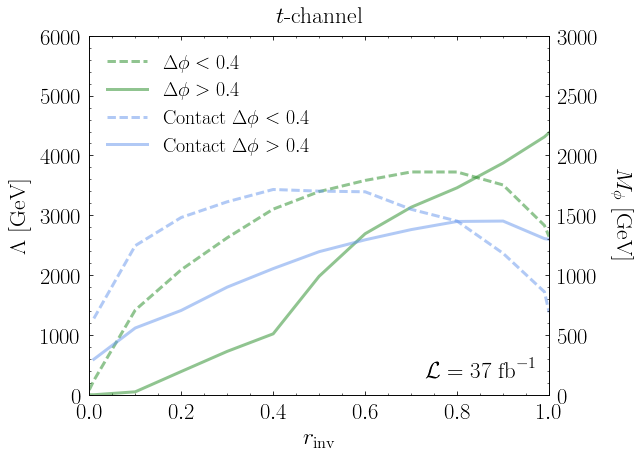

In [130]:
from scipy.optimize import fsolve


fig=plt.figure(figsize=(9,6.5))

title='$t$-channel'

mass_limit_less=np.zeros(len(rinvs))
mass_limit_gtr=np.zeros(len(rinvs))


for i,r in enumerate(rinvs):
    mymass = np.insert(masses,0,0)
    masslist_less = np.insert(result_less[i],0,0)
    masslist_gtr = np.insert(result_gtr[i],0,0)    
    mass_limit_less[i] = fsolve(lambda mZ: 1-np.interp(mZ, mymass, masslist_less), 200)[0]
    mass_limit_gtr[i] = fsolve(lambda mZ: 1-np.interp(mZ, mymass, masslist_gtr), 30)[0]


plt.plot(rinvs,2*mass_limit_less, label = r'$\Delta \phi < 0.4$',alpha=.5,lw=3., color='forestgreen', ls='--')
plt.plot(rinvs,2*mass_limit_gtr, label = r'$\Delta \phi > 0.4$',alpha=.5,lw=3., color='forestgreen')


plt.plot(rinvs[1:],2*interp1d(dp_cxn, masses_interp)(contact_cxn_less[1:]), label = r'Contact $\Delta \phi < 0.4$',alpha=.5,lw=3., ls='--', color='cornflowerblue')
plt.plot(rinvs[1:],2*interp1d(dp_cxn, masses_interp)(contact_cxn_gtr[1:]), label = r'Contact  $\Delta \phi > 0.4$',alpha=.5,lw=3., color='cornflowerblue')


# plt.plot(rinvs,contact_less, label = r'Contact $\Delta \phi < 0.4$',alpha=.5,lw=3., ls='--', color='cornflowerblue')
# plt.plot(rinvs,contact_gtr, label = r'Contact  $\Delta \phi > 0.4$',alpha=.5,lw=3., color='cornflowerblue')


# plt.yscale('log', nonposy='clip')
plt.xlabel(r'$r_{\rm inv}$',fontsize=fs_labels/1.1)
plt.ylabel("$\Lambda$ [GeV]",fontsize=fs_labels/1.1)
plt.xlim([0.01,1.0])
# plt.ylim([0, 5000])

plt.title(title, fontsize=fs_labels/1.1)


plt.legend(loc='upper left',
           fontsize=fs_legend/1.1, ncol=1,frameon=False, fancybox=True)

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

# ticklabels = ["$10^{-3}$","$10^{-2}$","$10^{-1}$","$1$","$10$","$10^2$"]

plt.tick_params(axis='both', which='major', labelsize=fs_ticks/1.1)
# ax.set_yticklabels(ticklabels)

# handles,labels = ax.get_legend_handles_labels()
# handles = [handles[i] for i in [1,3]] + [Line2D([],[],color='k')]  + [Line2D([],[],color='k',ls='--')] #, handles[2]]
# # handles = [Line2D([],[],color=plot_colorss[i]) for i in [1,3,5]] + [Line2D([],[],color='k')] + [Line2D([],[],color='k',ls='--')] #, handles[2]] + 
# labels = [labels[1], labels[3],r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$'] #, labels[2]]

# leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
#            fontsize=20, ncol=2,frameon=False,
#            handletextpad=.5,
#            borderaxespad=0.)

ax.set_ylim(0,6000)

# ax = plt.axes()
# ax.arrow(0.62, 0.8, 0., 0.2, head_width=0.01, head_length=0.1, fc='k', ec='k')
# plt.text(.64,.5,"Exclusion",fontsize=18)


ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])


# plt.text(.74,9200-7400, "$M_d = 10$ GeV", fontsize = 19)
# plt.text(.83,8570-7400, "$g_x = 1.0$", fontsize = 19)
# plt.text(.83,7900-7400, "$g_q = 0.1$", fontsize = 19)

# ax = plt.axes()
# ax.arrow(.36,8450, 0., -400, head_width=0.01, head_length=80, fc='k', ec='k')
# # plt.text(.20,7850,"Exclusion",fontsize=17)

plt.tick_params(axis='both', which='major', labelsize=fs_ticks/1.1)

ax2 = ax.twinx()

ax2.set_ylabel("$M_{\phi}$ [GeV]", rotation=270,labelpad=35, fontsize=fs_labels/1.1)

ax2.plot(rinvs, mass_limit_less, ls='--',lw=0)
ax2.set_ylim(0,3000)


plt.tick_params(axis='both', which='major', labelsize=fs_ticks/1.1)

plt.text(.73,140,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=fs_text)

plt.xlim(0.0,1)




# plt.ylim(0,5000)
plt.tight_layout()
# plt.savefig("tchannel_lambda_lims.pdf")





plt.show()

In [131]:
def gq_disp(MZ):
    B = 10.
    Ld = 20.
    gd = 1
    return 1e-2*(1./gd)*(np.sqrt(B/10.))*(MZ/3000.)**2.*(20./Ld)**(5./2.)

sigma_disp = [cxns[:,6][iMZ]*(gq_disp(MZ))**2 for iMZ, MZ in enumerate(masses)]

In [143]:
def get_cxn(mass):
    lm=np.log(mass)
    return 6*4*np.exp(3.11941*lm - 0.49164*lm**2 + 44.7486*np.log(1 - mass/13000.))

In [152]:
get_cxn(2500)

5.7359018896395183e-06

In [150]:
mqcd = np.linspace(500,2500,100)
cxn_qcd= get_cxn(mqcd)

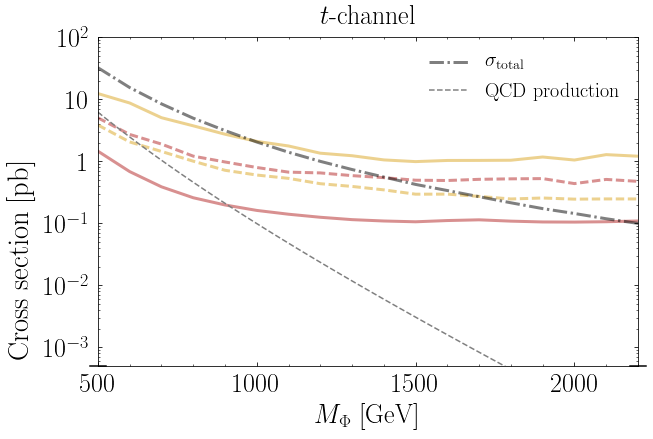

In [161]:


title='$t$-channel'


"""
Broken axis example, where the y-axis will have a portion cut out.
"""
import matplotlib.pylab as plt
# NEW:
import matplotlib.gridspec as gridspec
import numpy as np
plot_colors=['cornflowerblue','mediumseagreen', 'firebrick','indigo','violet','maroon','darkgrey','lightpink','black','forestgreen','cornflowerblue', 'salmon','violet','goldenrod','maroon','darkgrey','lightpink']


f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9,7.3))


ylim  = np.log10(np.array([5*1e-4,100]))
ylim2 = np.log10(np.array([8e-7, 1e-5]))

ylimratio = (ylim[1]-ylim[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
ylim2ratio = (ylim2[1]-ylim2[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
gs = gridspec.GridSpec(2, 1, height_ratios=[ylimratio, ylim2ratio])
ax = plt.subplot(gs[0])
# ax2 = plt.subplot(gs[1])
ax.set_ylim(ylim)
ax2.set_ylim(ylim2)

plt.subplots_adjust(hspace=-0.1)

ax2.plot(masses, sigma_disp, color='cornflowerblue' ,
         lw=3,alpha=.4,ls='--')


ax.plot(masses,cxns[:,-2]*result_less[-2,:],c='firebrick',alpha=.5 ,lw=3, ls='--')
ax.plot(masses,cxns[:,-2]*result_gtr[-2,:],c='firebrick',alpha=.5, lw=3, ls='-')


ax.plot(masses,cxns[:,6]*result_less[6,:],c='goldenrod',alpha=.5 ,lw=3, ls='--')
ax.plot(masses,cxns[:,6]*result_gtr[6,:],c='goldenrod',alpha=.5, lw=3, ls='-')

ax2.fill_between(masses, sigma_disp, np.zeros(len(sigma_disp)), color='cornflowerblue' ,
         lw=0,alpha=.1)


ax.plot(masses,cxns[:,10],
         c='k',ls='-.',alpha=.5, lw=3, label="$\sigma_\mathrm{total}$")

# f.xlabel(r'$M_{\Phi}$ [GeV]',fontsize=fs_labels)
ax2.set_xlabel(r'$\textrm{Cross~section}\; [{\rm pb}]$',fontsize=fs_labels)  


ax.set_yscale("log")
ax2.set_yscale("log")


# zoom-in / limit the view to different portions of the data
ax.set_ylim(5*1e-4,100)  # outliers only
ax2.set_ylim(8e-7, 1e-5)  # most of the data

ax.set_xlim(500,2200)
# hide the spines between ax and ax2
# ax.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax.xaxis.tick_top()
# ax.tick_params(labeltop='off')  # don't put tick labels at the top
# ax2.xaxis.tick_bottom()


ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))
# ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))

ax.tick_params(axis='both', which='major', labelsize=fs_labels)


# ax2.set_yticks([1e-6,1e-5],["453","43"])

ax2.tick_params(axis='both', which='major', labelsize=fs_labels)


ax.set_xlabel(r'$M_{\Phi}$ [GeV]',fontsize=fs_labels)  

ax2.set_xlim(500,2200)


# handles,labels = ax.get_legend_handles_labels()
# labels = ["$\Delta\phi < 0.4$","$\Delta\phi > 0.4$","","$r_\mathrm{inv}=0.9$","$r_\mathrm{inv}=0.5$","$\sigma_\mathrm{total}$"]
# handles = [Line2D([],[],color='k',ls='--')] + [Line2D([],[],color='k',ls='-')] +[Line2D([],[],alpha=0)]+[Line2D([],[],color='firebrick',ls='-')]+ [Line2D([],[],color='goldenrod',ls='-')] + [Line2D([],[],alpha=1, color='black',ls='-.')] + [Line2D([],[],color=plot_colors[i]) for i in range(3)] 

# ax.legend(handles, labels, loc='upper right',
#            fontsize=fs_legend, ncol=2
#            ,frameon=False, fancybox=True)

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (0, 0), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (0, 0), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 , 1 ), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1, 1), **kwargs)  # bottom-right diagonal


ax.plot(mqcd,cxn_qcd, color='grey',ls='--', label="QCD production")
f.text(0.01, 0.5, r'$\textrm{Cross~section}\; [{\rm pb}]$', va='center', rotation='vertical', fontsize=1.1*fs_labels)

ax2.text(550,1.1e-6,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=fs_text)
ax2.text(1600,1.6e-6,"Displaced mesons",fontsize=fs_text, color='cornflowerblue', rotation=1.3,alpha=0.8)

plt.setp(ax2.get_yminorticklabels(), visible=False)

ax.set_title(title, fontsize=fs_labels)


ax.legend(loc='upper right',
           fontsize=fs_legend/1.1, ncol=1,frameon=False, fancybox=True)

ttl = ax.title
ttl.set_position([.5, 1.02])



f.tight_layout()
plt.tight_layout()

plt.gcf().subplots_adjust(left=0.15)


# plt.savefig("tchannel_cxn_lims.pdf")

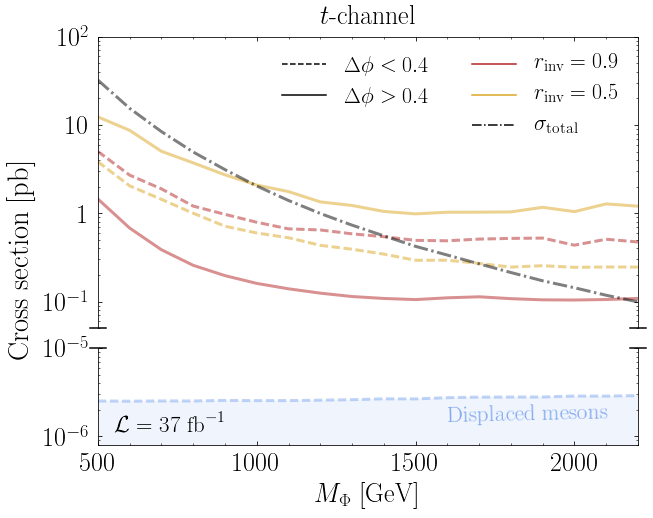

In [137]:


title='$t$-channel'


"""
Broken axis example, where the y-axis will have a portion cut out.
"""
import matplotlib.pylab as plt
# NEW:
import matplotlib.gridspec as gridspec
import numpy as np
plot_colors=['cornflowerblue','mediumseagreen', 'firebrick','indigo','violet','maroon','darkgrey','lightpink','black','forestgreen','cornflowerblue', 'salmon','violet','goldenrod','maroon','darkgrey','lightpink']


f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9,7.3))


ylim  = np.log10(np.array([5*1e-2,100]))
ylim2 = np.log10(np.array([8e-7, 1e-5]))

ylimratio = (ylim[1]-ylim[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
ylim2ratio = (ylim2[1]-ylim2[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
gs = gridspec.GridSpec(2, 1, height_ratios=[ylimratio, ylim2ratio])
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax.set_ylim(ylim)
ax2.set_ylim(ylim2)

plt.subplots_adjust(hspace=-0.1)

ax2.plot(masses, sigma_disp, color='cornflowerblue' ,
         lw=3,alpha=.4,ls='--')


ax.plot(masses,cxns[:,-2]*result_less[-2,:],c='firebrick',alpha=.5 ,lw=3, ls='--')
ax.plot(masses,cxns[:,-2]*result_gtr[-2,:],c='firebrick',alpha=.5, lw=3, ls='-')


ax.plot(masses,cxns[:,6]*result_less[6,:],c='goldenrod',alpha=.5 ,lw=3, ls='--')
ax.plot(masses,cxns[:,6]*result_gtr[6,:],c='goldenrod',alpha=.5, lw=3, ls='-')

ax2.fill_between(masses, sigma_disp, np.zeros(len(sigma_disp)), color='cornflowerblue' ,
         lw=0,alpha=.1)


ax.plot(masses,cxns[:,10],
         c='k',ls='-.',alpha=.5, lw=3, label="$\sigma_\mathrm{total}$")

# f.xlabel(r'$M_{\Phi}$ [GeV]',fontsize=fs_labels)
ax2.set_xlabel(r'$\textrm{Cross~section}\; [{\rm pb}]$',fontsize=fs_labels)  


ax.set_yscale("log")
ax2.set_yscale("log")


# zoom-in / limit the view to different portions of the data
ax.set_ylim(5*1e-2,100)  # outliers only
ax2.set_ylim(8e-7, 1e-5)  # most of the data

ax.set_xlim(500,2200)
# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))
# ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))

ax.tick_params(axis='both', which='major', labelsize=fs_labels)


# ax2.set_yticks([1e-6,1e-5],["453","43"])

ax2.tick_params(axis='both', which='major', labelsize=fs_labels)


ax2.set_xlabel(r'$M_{\Phi}$ [GeV]',fontsize=fs_labels)  

ax2.set_xlim(500,2200)


handles,labels = ax.get_legend_handles_labels()
labels = ["$\Delta\phi < 0.4$","$\Delta\phi > 0.4$","","$r_\mathrm{inv}=0.9$","$r_\mathrm{inv}=0.5$","$\sigma_\mathrm{total}$"]
handles = [Line2D([],[],color='k',ls='--')] + [Line2D([],[],color='k',ls='-')] +[Line2D([],[],alpha=0)]+[Line2D([],[],color='firebrick',ls='-')]+ [Line2D([],[],color='goldenrod',ls='-')] + [Line2D([],[],alpha=1, color='black',ls='-.')] + [Line2D([],[],color=plot_colors[i]) for i in range(3)] 

ax.legend(handles, labels, loc='upper right',
           fontsize=fs_legend, ncol=2
           ,frameon=False, fancybox=True)

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (0, 0), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (0, 0), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 , 1 ), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1, 1), **kwargs)  # bottom-right diagonal



f.text(0.01, 0.5, r'$\textrm{Cross~section}\; [{\rm pb}]$', va='center', rotation='vertical', fontsize=1.1*fs_labels)

ax2.text(550,1.1e-6,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=fs_text)
ax2.text(1600,1.6e-6,"Displaced mesons",fontsize=fs_text, color='cornflowerblue', rotation=1.3,alpha=0.8)

plt.setp(ax2.get_yminorticklabels(), visible=False)

ax.set_title(title, fontsize=fs_labels)


plt.legend(loc='upper left',
           fontsize=fs_legend/1.1, ncol=1,frameon=False, fancybox=True)

ttl = ax.title
ttl.set_position([.5, 1.02])



f.tight_layout()
plt.tight_layout()

plt.gcf().subplots_adjust(left=0.15)


# plt.savefig("tchannel_cxn_lims.pdf")

# s-channel limits

In [ ]:
rinvs = [0.0, 0.01,0.1,.2,.3,.4,.5,.6,.7,.8,.9, 0.99, 1.0]

In [752]:
# mass_lims_schannel = [    0.      ,     980.56156249 , 3327.41646839 , 3672.88945312 , 3751.77360285,
#   3623.8715439   , 3386.04270153 , 2937.37777449 , 2402.56258518  , 999.97841573,
#      0.    ,         0.        ,     0.        ]

mass_lims_schannel = [    0.,           380.36845131,  2301.97268068,  2727.84309789,  2758.51509539,
  2713.64559739,  2523.2249279,   2203.93694894,  1661.83490573,  1111.73572584,
     0. ,            0.         ,    0.        ]

mass_lims_schannel = [    0.  ,         333.76364598  ,2148.68546278  ,2516.79386298  ,2665.67456151,
  2543.5315253  , 2370.81840128  ,2077.12389912  ,1619.60743569,  1077.85734717,
     0.         ,    0.           ,  0.        ]


mass_lims_schannel = [    0.      ,     362.73515126 , 2217.25069976 , 2672.0204896   ,2728.9490603,
  2652.48424035 , 2474.73776734 , 2157.22562032 , 1645.85617429 , 1100.64541195,
     0.         ,    0.          ,   0.        ]


In [753]:
# mass_lims_dijets_schannel = [ 3088.10052123 , 3028.37356425 , 2663.24622078 , 22536299935  ,1887.8149791,
#   1480.83838644  ,   0.      ,       0. ,            0.        ,     0.      ,       0.,
#      0.       ,      0.        ]

mass_lims_dijets_schannel=[ 1935.63677909,  1909.48574306,  1660.40287658,  1395.13922946,   675.31258973,
     0.,             0.    ,         0. ,            0. ,            0.   ,          0.
,     0.  ,           0.        ]



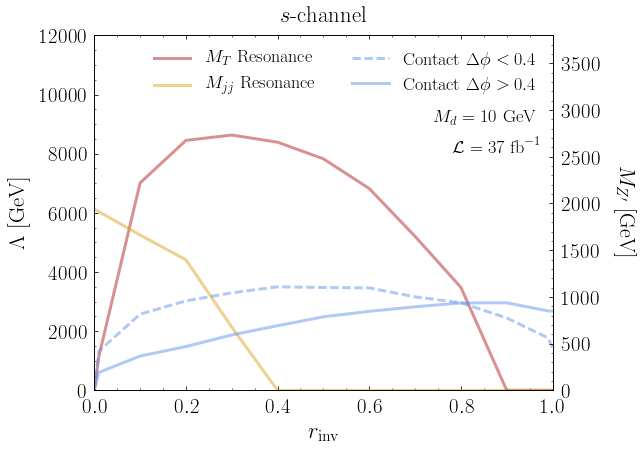

In [754]:
from scipy.optimize import fsolve
fig=plt.figure(figsize=(9,6.4))
title='$s$-channel'

# mass_limit_less=np.zeros(len(rinvs))
# mass_limit_gtr=np.zeros(len(rinvs))


# for i,r in enumerate(rinvs):
#     mymass = np.insert(masses,0,0)
#     masslist_less = np.insert(result_less[i],0,0)
#     masslist_gtr = np.insert(result_gtr[i],0,0)    
#     mass_limit_less[i] = fsolve(lambda mZ: 1-np.interp(mZ, mymass, masslist_less), 2.)[0]
#     mass_limit_gtr[i] = fsolve(lambda mZ: 1-np.interp(mZ, mymass, masslist_gtr), 2.)[0]


# final_limit=mass_limit
# print(mass_limit)


# final_limit[0]=0
# final_limit[1]=0
# cutoff = final_limit/np.sqrt(.1)
plt.plot(rinvs,mass_lims_schannel/np.sqrt(0.1), label = r'$M_T$ Resonance',alpha=.5,lw=3, color='firebrick', ls='-')
plt.plot(rinvs,mass_lims_dijets_schannel/np.sqrt(0.1), label = r'$M_{jj}$ Resonance',alpha=.5,lw=3, color='goldenrod', ls='-')


# plt.plot(rinvs,mass_lims_schannel/np.sqrt(0.1), label = r'$\Delta \phi > 0.4$',alpha=.5,lw=2.5, color='firebrick')

plt.plot(rinvs,contact_less, label = r'Contact $\Delta \phi < 0.4$',alpha=.5,lw=3, ls='--', color='cornflowerblue')
plt.plot(rinvs,contact_gtr, label = r'Contact  $\Delta \phi > 0.4$',alpha=.5,lw=3, color='cornflowerblue')


# plt.yscale('log', nonposy='clip')
plt.xlabel(r'$r_{\rm inv}$',fontsize=fs_labels/1.15)
plt.ylabel(r'$\Lambda$ [GeV]',fontsize=fs_labels/1.15)
plt.xlim([0.01,1.0])
# plt.ylim([0, 5000])

plt.title(title, fontsize=fs_labels/1.15)


plt.legend(loc='upper right',
           fontsize=20/1.1, ncol=2,frameon=False, fancybox=True)

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

# ticklabels = ["$10^{-3}$","$10^{-2}$","$10^{-1}$","$1$","$10$","$10^2$"]

plt.tick_params(axis='both', which='major', labelsize=fs_ticks/1.2)
# ax.set_yticklabels(ticklabels)

# handles,labels = ax.get_legend_handles_labels()
# handles = [handles[i] for i in [1,3]] + [Line2D([],[],color='k')]  + [Line2D([],[],color='k',ls='--')] #, handles[2]]
# # handles = [Line2D([],[],color=plot_colorss[i]) for i in [1,3,5]] + [Line2D([],[],color='k')] + [Line2D([],[],color='k',ls='--')] #, handles[2]] + 
# labels = [labels[1], labels[3],r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$'] #, labels[2]]

# leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
#            fontsize=20, ncol=2,frameon=False,
#            handletextpad=.5,
#            borderaxespad=0.)

ax.set_ylim(0,12000)

# ax = plt.axes()
# ax.arrow(0.62, 0.8, 0., 0.2, head_width=0.01, head_length=0.1, fc='k', ec='k')
# plt.text(.64,.5,"Exclusion",fontsize=18)


ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])


plt.text(.78,9200-1200, "$\mathcal L = 37~\mathrm{fb}^{-1}$", fontsize = 21/1.15)
plt.text(.74,9000, "$M_d = 10$ GeV", fontsize = 21/1.15)


# plt.text(.81,8370-2400, "$g_x = 1.0$", fontsize = 19)
# plt.text(.81,7550-2400, "$g_q = 0.1$", fontsize = 19)

ax = plt.axes()
# ax.arrow(.36,8450, 0., -400, head_width=0.01, head_length=80, fc='k', ec='k')
# plt.text(.20,7850,"Exclusion",fontsize=17)

ax2 = ax.twinx()

ax2.set_ylabel("$M_{Z'}$ [GeV]", rotation=270,labelpad=35, fontsize=fs_labels/1.2)

ax2.plot(rinvs, mass_lims_schannel, ls='--',lw=0)
ax2.set_ylim(0,3800)

plt.xlim(0.0,1)

plt.tight_layout()

plt.tick_params(axis='both', which='major', labelsize=fs_ticks/1.2)

# plt.ylim(0,3000)
plt.tight_layout()
# plt.savefig("sChannelLims_Tim.pdf")

plt.savefig("schannel_lambda_lims.pdf")
# plt.savefig("sChannelLims_Tim.pdf")



plt.show()




In [8]:
import os
masses_rename = list(np.arange(500,3500,500))+[5000,10000]
rinvs_rename = [0.0, 0.01,0.1,.2,.3,.4,.5,.6,.7,.8,.9, 0.99, 1.0]

base_dir = "/group/hepheno/smsharma/Dark-Showers/data/sig_tchannel/hepmc/"

for mass in tqdm(masses_rename):
    for rinv in tqdm(rinvs_rename):
        for inum in range(3):
            os.system("mv " + base_dir + "events_hepmc_M" + str(mass) + "_rinv" + to_str(rinv) +"_"+str(inum) + " " + base_dir +"/events_hepmc_M" + str(mass) + "_rinv" + str(rinv) +"_"+str(inum)+".hepmc")

100%|██████████| 8/8 [00:03<00:00,  2.52it/s]


# Fig. 2: Number of dark hadrons

In [755]:
Nc=2
NFf=2

b = 11./3 *Nc - 2./3. * NFf

def alpha_d(lambda_d):
    return 2*np.pi / (b*np.log(1000/lambda_d))

In [756]:
# Coupling at 10 and 100 GeV
print "Coupling strength at \Lambda_d = 10 GeV is", alpha_d(10)
print "Coupling strength at \Lambda_d = 10 GeV is", alpha_d(100)

Coupling strength at \Lambda_d = 10 GeV is 0.227396058974
Coupling strength at \Lambda_d = 10 GeV is 0.454792117947


In [759]:
# Load events and grab number of dark mesons

lambda_range = np.linspace(1, 400, 10)
rinv_range = np.linspace(0,1,10)
nmeson = np.zeros((len(lambda_range),len(rinv_range)))

for ilambda, lambdo in enumerate(lambda_range):
    for irinv,rinv in enumerate(rinv_range):
        nmeson[ilambda,irinv] =np.mean(pd.read_csv("../gen/nDarkScan/out_" + str(lambdo) + "_"+ str(rinv)[:5]+".evt", header=0, delimiter=',', skipinitialspace=True)['n_meson'])

fig, ax = plt.subplots(figsize=(8,6.3))
a = np.nan_to_num(nmeson[:-1, :-1])
N = 10
Y, X = np.mgrid[alphad(1):alphad(400):complex(0, N), 0:1:complex(0, N)]

plt.pcolor(X, Y,a/2,cmap='plasma', vmin=0, vmax=10)
plt.xlabel("$r_\mathrm{inv}$", fontsize=23)
plt.ylabel("$\\alpha_d$ (1 TeV)", fontsize=23)
cbar = plt.colorbar()
axis = plt.gca()
# axis.set_aspect('equal') # X scale matches Y scale
# plt.text( .8, .22,"fds", fontsize=22)
plt.title("$M_d = 10$ GeV", fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
cbar.ax.tick_params(labelsize=22) 
cbar.set_label(label="$n_\mathrm{dark}$", fontsize=26, rotation=270, labelpad = 15)
plt.savefig("ndmesons_md10.pdf")

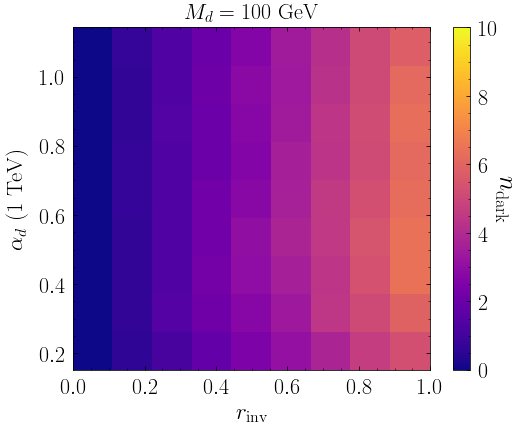

In [438]:
# Load events and grab number of dark mesons

lambda_range = np.linspace(1, 400, 10)
rinv_range = np.linspace(0,1,10)
nmeson = np.zeros((len(lambda_range),len(rinv_range)))

for ilambda, lambdo in enumerate(lambda_range):
    for irinv,rinv in enumerate(rinv_range):
        nmeson[ilambda,irinv] =np.mean(pd.read_csv("../gen/out_100_" + str(lambdo) + "_"+ str(rinv)[:5]+".evt", header=0, delimiter=',', skipinitialspace=True)['n_meson'])

fig, ax = plt.subplots(figsize=(8,6.3))
a = np.nan_to_num(nmeson[:-1, :-1])
N = 10
Y, X = np.mgrid[alphad(1):alphad(400):complex(0, N), 0:1:complex(0, N)]

plt.pcolor(X, Y,a/2,cmap='plasma', vmin=0, vmax=10)
plt.xlabel("$r_\mathrm{inv}$", fontsize=23)
plt.ylabel("$\\alpha_d$ (1 TeV)", fontsize=23)
cbar = plt.colorbar()
axis = plt.gca()
# axis.set_aspect('equal') # X scale matches Y scale
# plt.text( .8, .22,"fds", fontsize=22)
plt.title("$M_d = 100$ GeV", fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
cbar.ax.tick_params(labelsize=22) 
cbar.set_label(label="$n_\mathrm{dark}$", fontsize=26, rotation=270, labelpad = 15)
plt.savefig("ndmesons_md100.pdf")